In [17]:
import time
import torch
from torch import nn
from ml_models import SuperResolutionNet
from datasets import SRDataset
from utils import *
import numpy as np
from scipy.interpolate import interp2d, RectBivariateSpline
from importlib import reload  

import pylab as plt
%matplotlib inline

import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)

# Data parameters
data_folder = './exp2'  # folder with JSON data files
scaling_factor = 8  # the scaling factor for the generator; the input LR images will be downsampled from the target HR images by this factor


In [2]:
import diagnostics

def cal_enstrophy_spec(field2d):
    spec = diagnostics.grid2spec(field2d)
    return diagnostics.prod_spectrum(spec, spec)

def BivariateSplineInterp(low_res, scaling_factor):
    num_rows, num_cols = low_res.shape
    interp_f = RectBivariateSpline(np.linspace(0, 1, num_rows), np.linspace(0, 1, num_cols), low_res)

    interp_array = np.zeros((num_rows*scaling_factor, num_cols*scaling_factor))
    high_res_x = np.linspace(0, 1, num_rows * scaling_factor)
    high_res_y = np.linspace(0, 1, num_cols * scaling_factor)
    for i in range(num_rows * scaling_factor):
        for j in range(num_cols * scaling_factor):
            interp_array[i, j] = interp_f(high_res_x[i], high_res_y[j])
    
    return interp_array


In [41]:
train_dataset = SRDataset(data_folder,
                          scaling_factor=scaling_factor)
low_res, high_res = train_dataset[10]

In [42]:
checkpoint = torch.load("epoch_99_checkpoint_srnet.pth.tar")
model = checkpoint['model'].module.cpu()

In [43]:
with torch.no_grad():
    super_res = model(low_res[np.newaxis, :, :]).reshape(high_res.shape).detach().cpu().numpy()

interped_res = BivariateSplineInterp(low_res, scaling_factor)

/home/juchai/jaxcfd_venv/lib/python3.6/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Text(0.5, 1.0, 'SplineInterp')

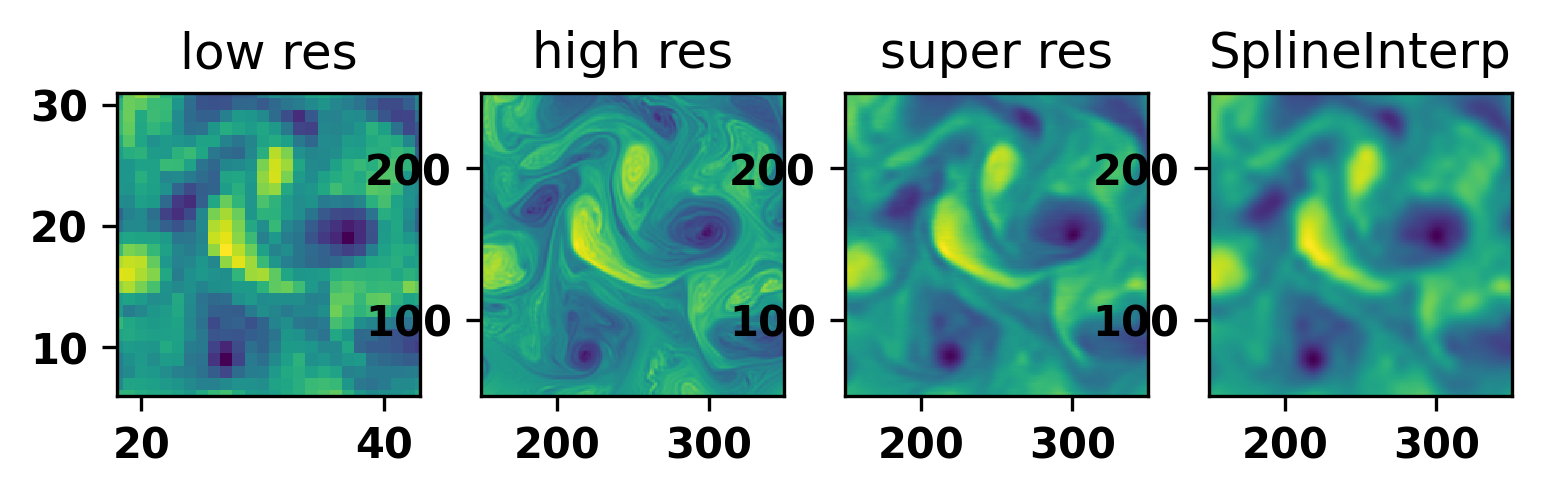

In [44]:
plt.figure(dpi= 300)

high_res_xlim = [150, 350]
high_res_ylim = [50, 250]

plt.subplot(1, 4, 1)
plt.imshow(low_res.T, interpolation='none')
if high_res_xlim is not None:
    plt.xlim([high_res_xlim[0]//scaling_factor, high_res_xlim[1]//scaling_factor])
    plt.ylim([high_res_ylim[0]//scaling_factor, high_res_ylim[1]//scaling_factor])
plt.title("low res")

plt.subplot(1, 4, 2)
plt.imshow(high_res.T, interpolation='none')
if high_res_xlim is not None:
    plt.xlim([high_res_xlim[0], high_res_xlim[1]])
    plt.ylim([high_res_ylim[0], high_res_ylim[1]])
plt.title("high res")

plt.subplot(1, 4, 3)
plt.imshow(super_res.T, interpolation='none')
if high_res_xlim is not None:
    plt.xlim([high_res_xlim[0], high_res_xlim[1]])
    plt.ylim([high_res_ylim[0], high_res_ylim[1]])
plt.title("super res")

plt.subplot(1, 4, 4)
plt.imshow(interped_res.T, interpolation='none')
if high_res_xlim is not None:
    plt.xlim([high_res_xlim[0], high_res_xlim[1]])
    plt.ylim([high_res_ylim[0], high_res_ylim[1]])
plt.title("SplineInterp")

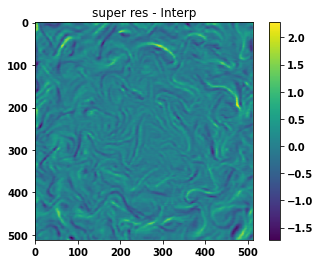

In [39]:
plt.imshow(super_res.T - interped_res.T, interpolation='none')
# if high_res_xlim is not None:
#     plt.xlim([high_res_xlim[0], high_res_xlim[1]])
#     plt.ylim([high_res_ylim[0], high_res_ylim[1]])
plt.title("super res - Interp")
plt.colorbar()

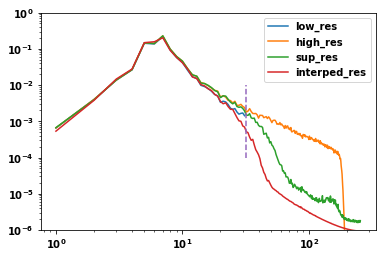

In [54]:
for field_name, field_value in [("low_res", low_res), ("high_res", high_res), 
                                ("sup_res", super_res), ("interped_res", interped_res)]:
    if isinstance(field_value, torch.Tensor):
        field_value = field_value.numpy()
    spec = cal_enstrophy_spec(field_value)
    plt.loglog(*spec, label=field_name)

plt.plot([32, 32], [1e-4, 1e-2], "--")
plt.ylim([1e-6, 1])

plt.legend()